In [3]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from implementations import ridge_regression, least_squares, build_k_indices
%load_ext autoreload
%autoreload 2

## Load the training data into feature matrix, class labels, and event ids:

In [4]:
from proj1_helpers import *
DATA_TRAIN_PATH = '/home/toinou/course/ml/ml_proj1/data/train.csv' 
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

tX.T[[22,-1]] = tX.T[[-1,22]]

In [102]:
## Preprocessing

def one_hot_jet_num(tX, idx=-1):
 
    #extract the jet_num column
    one_hot = tX[:,idx].astype(int)
    jet_num = np.zeros((tX.shape[0], 4))
    
    #create one column for each possible valur of jet_num
    jet_num[np.where(one_hot == 0),0] = 1
    jet_num[np.where(one_hot == 1),1] = 1
    jet_num[np.where(one_hot == 2),2] = 1
    jet_num[np.where(one_hot == 3),3] = 1

    #create empty array to contain the  new values 
    tX_hot = np.empty((tX.shape[0], 30+3))
    
    #fill the new array without jet_num
    tX_hot[:,:-4] = tX[:,:-1]

    #add the 4 news columns
    tX_hot[:,[-4,-3,-2,-1]] = jet_num
    return tX_hot

""" -- Data cleaning -- """

def cross_validation_ridge(y, x, k_indices, k, lambda_):
    
    x_test = x[k_indices[k]]
    y_test = y[k_indices[k]]
    x_train = x[np.concatenate(([x_train for i,x_train in enumerate(k_indices) if i!=k]), axis=0)]
    y_train = y[np.concatenate(([y_train for i,y_train in enumerate(k_indices) if i!=k]), axis=0)]
    
    w, mse = ridge_regression(y_train, x_train, lambda_)
    
    
    loss_tr = compute_mse(y_train,x_train,w)
    loss_te = compute_mse(y_test ,x_test ,w)
    """
    loss_tr = compute_acc(y_train,x_train,w)
    loss_te = compute_acc(y_test ,x_test ,w)
    """
    return loss_tr, loss_te, w

def cross_validation_ridge_3split(pred_0, pred_1, pred_2,
                                  dat_0_, dat_1_, dat_2_,
                                  inds_0, inds_1, inds_2,
                                  k_indices, k, lambda_,error=True):
    
    idx_te_0 = np.where(np.in1d(inds_0, k_indices[k]))[0]
    idx_te_1 = np.where(np.in1d(inds_1, k_indices[k]))[0]
    idx_te_2 = np.where(np.in1d(inds_2, k_indices[k]))[0]
    x_te_0 = dat_0_[idx_te_0]
    x_te_1 = dat_1_[idx_te_1]
    x_te_2 = dat_2_[idx_te_2]
    y_te_0 = pred_0[idx_te_0]
    y_te_1 = pred_1[idx_te_1]
    y_te_2 = pred_2[idx_te_2]
    
    idx_train = list(set(range(len(dat_0_)+len(dat_1_)+len(dat_2_))) - set(k_indices[k]))
    idx_tr_0 = np.where(np.in1d(inds_0, idx_train))[0]
    idx_tr_1 = np.where(np.in1d(inds_1, idx_train))[0]
    idx_tr_2 = np.where(np.in1d(inds_2, idx_train))[0]
    x_tr_0 = dat_0_[idx_tr_0]
    x_tr_1 = dat_1_[idx_tr_1]
    x_tr_2 = dat_2_[idx_tr_2]
    y_tr_0 = pred_0[idx_tr_0]
    y_tr_1 = pred_1[idx_tr_1]
    y_tr_2 = pred_2[idx_tr_2]
    
    #optimized value for lambda for each jet_num subset
    w_0,loss = ridge_regression(y_tr_0, x_tr_0, lambda_[0])
    w_1,loss = ridge_regression(y_tr_1, x_tr_1, lambda_[1])
    w_2,loss = ridge_regression(y_tr_2, x_tr_2, lambda_[2])   
    
    if error:
        loss_tr = compute_mse_3split(y_tr_0, y_tr_1, y_tr_2,
                                     x_tr_0, x_tr_1, x_tr_2,
                                     idx_tr_0, idx_tr_1, idx_tr_2,
                                     [w_0,w_1,w_2])
        loss_te = compute_mse_3split(y_te_0, y_te_1, y_te_2,
                                     x_te_0, x_te_1, x_te_2,
                                     idx_te_0, idx_te_1, idx_te_2,
                                     [w_0,w_1,w_2])
    else:
    
        loss_tr = compute_acc_3split(y_tr_0, y_tr_1, y_tr_2,
                                     x_tr_0, x_tr_1, x_tr_2,
                                     idx_tr_0, idx_tr_1, idx_tr_2,
                                     [w_0,w_1,w_2])
        loss_te = compute_acc_3split(y_te_0, y_te_1, y_te_2,
                                     x_te_0, x_te_1, x_te_2,
                                     idx_te_0, idx_te_1, idx_te_2,
                                     [w_0,w_1,w_2])

    return loss_tr, loss_te, [w_0,w_1,w_2]

def cross_validation_ls(y, x, k_indices, k):
    
    x_test = x[k_indices[k]]
    y_test = y[k_indices[k]]
    x_train = x[np.concatenate(([x_train for i,x_train in enumerate(k_indices) if i!=k]), axis=0)]
    y_train = y[np.concatenate(([y_train for i,y_train in enumerate(k_indices) if i!=k]), axis=0)]
    
    w, loss = least_squares(y_train, x_train)
    
    
    loss_tr = compute_mse(y_train,x_train,w)
    loss_te = compute_mse(y_test ,x_test ,w)
    """
    loss_tr = compute_acc(y_train,x_train,w)
    loss_te = compute_acc(y_test ,x_test ,w)
    """
    return loss_tr, loss_te, w

def cross_validation_ls_3split(pred_0, pred_1, pred_2,
                               dat_0_, dat_1_, dat_2_,
                               inds_0, inds_1, inds_2,
                               k_indices, k,error=True):
    
    idx_te_0 = np.where(np.in1d(inds_0, k_indices[k]))[0]
    idx_te_1 = np.where(np.in1d(inds_1, k_indices[k]))[0]
    idx_te_2 = np.where(np.in1d(inds_2, k_indices[k]))[0]
    x_te_0 = dat_0_[idx_te_0]
    x_te_1 = dat_1_[idx_te_1]
    x_te_2 = dat_2_[idx_te_2]
    y_te_0 = pred_0[idx_te_0]
    y_te_1 = pred_1[idx_te_1]
    y_te_2 = pred_2[idx_te_2]
    
    idx_train = list(set(range(len(dat_0_)+len(dat_1_)+len(dat_2_))) - set(k_indices[k]))
    idx_tr_0 = np.where(np.in1d(inds_0, idx_train))[0]
    idx_tr_1 = np.where(np.in1d(inds_1, idx_train))[0]
    idx_tr_2 = np.where(np.in1d(inds_2, idx_train))[0]
    x_tr_0 = dat_0_[idx_tr_0]
    x_tr_1 = dat_1_[idx_tr_1]
    x_tr_2 = dat_2_[idx_tr_2]
    y_tr_0 = pred_0[idx_tr_0]
    y_tr_1 = pred_1[idx_tr_1]
    y_tr_2 = pred_2[idx_tr_2]

    w_0, loss = least_squares(y_tr_0, x_tr_0)
    w_1, loss = least_squares(y_tr_1, x_tr_1)
    w_2, loss = least_squares(y_tr_2, x_tr_2)
    
    if error:
        loss_tr = compute_mse_3split(y_tr_0, y_tr_1, y_tr_2,
                                     x_tr_0, x_tr_1, x_tr_2,
                                     idx_tr_0, idx_tr_1, idx_tr_2,
                                     [w_0,w_1,w_2])
        loss_te = compute_mse_3split(y_te_0, y_te_1, y_te_2,
                                     x_te_0, x_te_1, x_te_2,
                                     idx_te_0, idx_te_1, idx_te_2,
                                     [w_0,w_1,w_2])
    else:
    
        loss_tr = compute_acc_3split(y_tr_0, y_tr_1, y_tr_2,
                                     x_tr_0, x_tr_1, x_tr_2,
                                     idx_tr_0, idx_tr_1, idx_tr_2,
                                     [w_0,w_1,w_2])
        loss_te = compute_acc_3split(y_te_0, y_te_1, y_te_2,
                                     x_te_0, x_te_1, x_te_2,
                                     idx_te_0, idx_te_1, idx_te_2,
                                     [w_0,w_1,w_2])
    
    return loss_tr, loss_te, [w_0,w_1,w_2]


def cross_validation_logreg(y, x, k_indices, k, gamma, steps):
    
    x_test = x[k_indices[k]]
    y_test = y[k_indices[k]]
    x_train = x[np.concatenate(([x_train for i,x_train in enumerate(k_indices) if i!=k]), axis=0)]
    y_train = y[np.concatenate(([y_train for i,y_train in enumerate(k_indices) if i!=k]), axis=0)]
    
    #starting with random weights
    w = np.random.rand(x_train.shape[1],)
    for step in range(steps):
        loss, w = learning_by_gradient_descent(y_train, x_train, w, gamma)
    
    """
    loss_tr = compute_mse(y_train,x_train,w)
    loss_te = compute_mse(y_test ,x_test ,w)
    """
    loss_tr = compute_acc(y_train,x_train,w)
    loss_te = compute_acc(y_test ,x_test ,w)
    
    return loss_tr, loss_te, w

def cross_validation_logreg_3split(pred_0, pred_1, pred_2,
                                   dat_0_, dat_1_, dat_2_,
                                   inds_0, inds_1, inds_2,
                                   k_indices, k, gamma, steps,
                                   error=True):
    
    idx_te_0 = np.where(np.in1d(inds_0, k_indices[k]))[0]
    idx_te_1 = np.where(np.in1d(inds_1, k_indices[k]))[0]
    idx_te_2 = np.where(np.in1d(inds_2, k_indices[k]))[0]
    x_te_0 = dat_0_[idx_te_0]
    x_te_1 = dat_1_[idx_te_1]
    x_te_2 = dat_2_[idx_te_2]
    y_te_0 = pred_0[idx_te_0]
    y_te_1 = pred_1[idx_te_1]
    y_te_2 = pred_2[idx_te_2]
    
    idx_train = list(set(range(len(dat_0_)+len(dat_1_)+len(dat_2_))) - set(k_indices[k]))
    idx_tr_0 = np.where(np.in1d(inds_0, idx_train))[0]
    idx_tr_1 = np.where(np.in1d(inds_1, idx_train))[0]
    idx_tr_2 = np.where(np.in1d(inds_2, idx_train))[0]
    x_tr_0 = dat_0_[idx_tr_0]
    x_tr_1 = dat_1_[idx_tr_1]
    x_tr_2 = dat_2_[idx_tr_2]
    y_tr_0 = pred_0[idx_tr_0]
    y_tr_1 = pred_1[idx_tr_1]
    y_tr_2 = pred_2[idx_tr_2]
    
    w_0 = np.zeros(x_tr_0.shape[1],)
    w_1 = np.zeros(x_tr_1.shape[1],)
    w_2 = np.zeros(x_tr_2.shape[1],)

    for step in range(steps):
        loss, w_0 = learning_by_gradient_descent(y_tr_0, x_tr_0, w_0, gamma)
        loss, w_1 = learning_by_gradient_descent(y_tr_1, x_tr_1, w_1, gamma)
        loss, w_2 = learning_by_gradient_descent(y_tr_2, x_tr_2, w_2, gamma)
    
    if error:
        loss_tr = compute_mse_3split(y_tr_0, y_tr_1, y_tr_2,
                                     x_tr_0, x_tr_1, x_tr_2,
                                     idx_tr_0, idx_tr_1, idx_tr_2,
                                     [w_0,w_1,w_2])
        loss_te = compute_mse_3split(y_te_0, y_te_1, y_te_2,
                                     x_te_0, x_te_1, x_te_2,
                                     idx_te_0, idx_te_1, idx_te_2,
                                     [w_0,w_1,w_2])
    else:
    
        loss_tr = compute_acc_3split(y_tr_0, y_tr_1, y_tr_2,
                                     x_tr_0, x_tr_1, x_tr_2,
                                     idx_tr_0, idx_tr_1, idx_tr_2,
                                     [w_0,w_1,w_2])
        loss_te = compute_acc_3split(y_te_0, y_te_1, y_te_2,
                                     x_te_0, x_te_1, x_te_2,
                                     idx_te_0, idx_te_1, idx_te_2,
                                     [w_0,w_1,w_2])
    
    return loss_tr, loss_te, [w_0,w_1,w_2]

def compute_mse_3split(pred_0, pred_1, pred_2,
                       x_0, x_1, x_2,
                       inds_0, inds_1, inds_2,
                       w):
    """Calculate the loss using mse."""
        
    y_pred_0 = predict_labels(w[0], x_0)
    y_pred_1 = predict_labels(w[1], x_1)
    y_pred_2 = predict_labels(w[2], x_2)
    
    #replacing the prediction in fornt of the original idx
    pred = np.array(list(y_pred_0)+list(y_pred_1)+list(y_pred_2))

    #recreate the initial y
    y = np.array(list(pred_0)+list(pred_1)+list(pred_2))

    losses = np.empty((y.shape[0]))
    error = y - pred
    cte = 1/(2*y.shape[0])
    losses = cte*np.dot(error.T,error)
    
    return losses

def compute_acc_3split(pred_0, pred_1, pred_2,
                       x_0, x_1, x_2,
                       inds_0, inds_1, inds_2,
                       w):
    """Calculate the loss using mse."""
        
    y_pred_0 = predict_labels(w[0], x_0)
    y_pred_1 = predict_labels(w[1], x_1)
    y_pred_2 = predict_labels(w[2], x_2)
    
    #replacing the prediction in fornt of the original idx
    pred = np.concatenate((y_pred_0,y_pred_1,y_pred_2),axis=0)

    #recreate the initial y
    y = np.concatenate((pred_0,pred_1,pred_2),axis=0)
    
    tmp = pred*y
    return tmp[np.where(tmp==1)].shape[0]/tmp.shape[0]

def compute_acc(y, tx, w):
    """Calculate the loss using mse."""
    
    pred = predict_labels(w, tx)
    tmp = pred*y
    return tmp[np.where(tmp==1)].shape[0]/tmp.shape[0]

In [34]:
from implementations import *
from proj1_helpers import *
DATA_TRAIN_PATH = '/home/toinou/course/ml/ml_proj1/data/train.csv' 
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)
tX.T[[22,-1]] = tX.T[[-1,22]]


seed = 672581
k_fold = 4
lambdas = np.logspace(-20,1,21)
degrees = 12

feats_to_keeps = [
    [0, 2, 10, 20, 38, 21, 23, 3, 32, 16, 19, 37, 1, 18, 29, 54, 26, 43, 7, 28, 13, 39, 41, 34, 52, 8, 44, 25, 17, 24, 27, 4, 42, 31, 35, 14, 9, 45, 50, 22, 51, 53, 47, 40, 48, 12, 15, 6, 33, 11, 30, 36, 5, 46, 49][:49],
    [0, 2, 10, 43, 9, 36, 24, 31, 76, 19, 5, 27, 3, 13, 71, 47, 57, 33, 8, 38, 6, 49, 87, 53, 30, 1, 23, 45, 69, 18, 25, 4, 16, 64, 40, 62, 84, 68, 46, 74, 29, 67, 75, 70, 80, 28, 17, 51, 86, 7, 72, 50, 58, 77, 26, 82, 37, 32, 55, 83, 35, 21, 65, 12, 59, 15, 11, 42, 41, 14, 61, 78, 34, 39, 66, 56, 22, 81, 44, 88, 54, 60, 48, 63, 20, 85, 73, 52, 79][:83],
    [0, 34, 12, 14, 9, 71, 2, 47, 8, 37, 149, 22, 124, 30, 101, 5, 63, 88, 1, 59, 146, 117, 62, 44, 27, 36, 41, 100, 31, 168, 154, 67, 23, 24, 3, 17, 32, 90, 153, 66, 70, 7, 173, 165, 46, 119, 56, 139, 85, 53, 20, 4, 114, 43, 61, 148, 150, 170, 10, 128, 92, 121, 11, 6, 93, 35, 64, 122, 151, 159, 147, 60, 89, 118, 125, 18, 141, 157, 65, 115, 57, 82, 111, 143, 99, 28, 52, 51, 80, 142, 13, 129, 160, 152, 94, 163, 26, 39, 126, 40, 69, 167, 96, 105, 123, 58, 116, 50, 135, 120, 33, 91, 95, 136, 112, 73, 130, 131, 15, 25, 83, 21, 137, 79, 84, 98, 156, 127, 75, 68, 45, 161, 103, 174, 48, 171, 55, 113, 172, 102, 109, 138, 54, 72, 108, 166, 16, 132, 107, 155, 104, 164, 106, 110, 77, 19, 134, 76, 145, 87, 29, 81, 133, 144, 86, 74, 78, 49, 169, 140, 162, 97, 158, 42, 38][:168]
                 ]

y_0, y_1, y_2, dat_tr0, dat_tr1, dat_tr2, idx_tr0, idx_tr1, idx_tr2 = split_jet_num(y   ,tX)

rmse_tr_0_opt = []
rmse_te_0_opt = []
rmse_tr_1_opt = []
rmse_te_1_opt = []
rmse_tr_2_opt = []
rmse_te_2_opt = []
rmse_tr_3_opt = []
rmse_te_3_opt = []


ws_0_opt = []
ws_1_opt = []
ws_2_opt = []
ws_3_opt = []


ind_te_0_opt_lambda = 0
ind_te_1_opt_lambda = 0
ind_te_2_opt_lambda = 0
ind_te_3_opt_lambda = 0
ind_tr_0_opt_lambda = 0
ind_tr_1_opt_lambda = 0
ind_tr_2_opt_lambda = 0
ind_tr_3_opt_lambda = 0


for deg in range(1, degrees):

    #log-transform, augment features using polynomial basis and standardize the subsets individualy
    tx_tr0, tr0_mean, tr0_std = preprocessing(dat_i=dat_tr0, degree=deg)
    tx_tr1, tr1_mean, tr1_std = preprocessing(dat_i=dat_tr1, degree=deg)
    tx_tr2, tr2_mean, tr2_std = preprocessing(dat_i=dat_tr2, degree=deg)

    # split data in k fold
    k_indices_0 = build_k_indices(y_0, k_fold, seed)
    k_indices_1 = build_k_indices(y_1, k_fold, seed)
    k_indices_2 = build_k_indices(y_2, k_fold, seed)
    #k_indices_3 = build_k_indices(pred_3, k_fold, seed)

    rmse_tr_0 = []
    rmse_te_0 = []
    rmse_tr_1 = []
    rmse_te_1 = []
    rmse_tr_2 = []
    rmse_te_2 = []
    rmse_tr_3 = []
    rmse_te_3 = []

    ws_0 =[]
    ws_1 =[]
    ws_2 =[]
    ws_3 =[]

    #for lambda_ in lambdas:
    for lambda_ in lambdas:
        rmse_tr_tmp_0 = []
        rmse_te_tmp_0 = []
        rmse_tr_tmp_1 = []
        rmse_te_tmp_1 = []
        rmse_tr_tmp_2 = []
        rmse_te_tmp_2 = []
        rmse_tr_tmp_3 = []
        rmse_te_tmp_3 = []
        
        for k in range(k_fold):
            loss_tr_0, loss_te_0, w_0 = cross_validation_ridge(y_0, tx_tr0, k_indices_0, k, lambda_)
            loss_tr_1, loss_te_1, w_1 = cross_validation_ridge(y_1, tx_tr1, k_indices_1, k, lambda_)
            loss_tr_2, loss_te_2, w_2 = cross_validation_ridge(y_2, tx_tr2, k_indices_2, k, lambda_)
            #loss_tr_3, loss_te_3, w_3 = cross_validation_ridge(pred_3, dat_3_, k_indices_3, k, lambda_)
            
            loss_tr_3, loss_te_3, w_3 = 0, 0, 0
            
            rmse_tr_tmp_0.append(loss_tr_0)
            rmse_te_tmp_0.append(loss_te_0)
            rmse_tr_tmp_1.append(loss_tr_1)
            rmse_te_tmp_1.append(loss_te_1)
            rmse_tr_tmp_2.append(loss_tr_2)
            rmse_te_tmp_2.append(loss_te_2)
            rmse_tr_tmp_3.append(loss_tr_3)
            rmse_te_tmp_3.append(loss_te_3)
        ws_0.append(w_0)
        ws_1.append(w_1)
        ws_2.append(w_2)
        ws_3.append(w_3)

        #combine the loss over the folds
        rmse_tr_0.append(np.mean(rmse_tr_tmp_0))
        rmse_te_0.append(np.mean(rmse_te_tmp_0))
        rmse_tr_1.append(np.mean(rmse_tr_tmp_1))
        rmse_te_1.append(np.mean(rmse_te_tmp_1))
        rmse_tr_2.append(np.mean(rmse_tr_tmp_2))
        rmse_te_2.append(np.mean(rmse_te_tmp_2))
        rmse_tr_3.append(np.mean(rmse_tr_tmp_3))
        rmse_te_3.append(np.mean(rmse_te_tmp_3))

    #Index all the optimal lambda
    ind_tr_0_opt_lambda = np.argmin(rmse_tr_0)
    ind_te_0_opt_lambda = np.argmin(rmse_te_0)
    ind_tr_1_opt_lambda = np.argmin(rmse_tr_1)
    ind_te_1_opt_lambda = np.argmin(rmse_te_1)
    ind_tr_2_opt_lambda = np.argmin(rmse_tr_2)
    ind_te_2_opt_lambda = np.argmin(rmse_te_2)
    ind_tr_3_opt_lambda = np.argmin(rmse_tr_3)
    ind_te_3_opt_lambda = np.argmin(rmse_te_3)
        
    #Store the optimal weights for each category (0,1 or 2)
    ws_0_opt.append(ws_0[ind_te_0_opt_lambda])
    ws_1_opt.append(ws_1[ind_te_1_opt_lambda])
    ws_2_opt.append(ws_2[ind_te_2_opt_lambda])
    ws_3_opt.append(ws_3[ind_te_3_opt_lambda])

    #Define the optimal degree and lambda for each category (0,1 or 2)
    rmse_tr_0_opt.append(rmse_tr_0[ind_tr_0_opt_lambda])
    rmse_te_0_opt.append(rmse_te_0[ind_te_0_opt_lambda])
    rmse_tr_1_opt.append(rmse_tr_1[ind_tr_1_opt_lambda])
    rmse_te_1_opt.append(rmse_te_1[ind_te_1_opt_lambda])
    rmse_tr_2_opt.append(rmse_tr_2[ind_tr_2_opt_lambda])
    rmse_te_2_opt.append(rmse_te_2[ind_te_2_opt_lambda])
    rmse_tr_3_opt.append(rmse_tr_3[ind_tr_3_opt_lambda])
    rmse_te_3_opt.append(rmse_te_3[ind_te_3_opt_lambda])

/home/toinou/Documents/master/ma1/ml/ml_proj1/scripts/proj1_helpers.py:93: RuntimeWarning: Mean of empty slice
  nan_mean = np.nanmean(tx, axis=0)


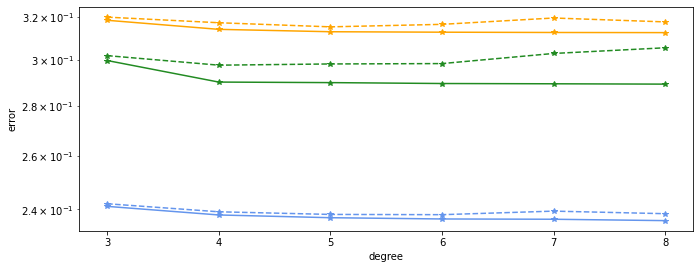

In [41]:
f = plt.figure(figsize=(11,14)) # change this if needed

degrees = 9
#degree 1
ax1 = f.add_subplot(311)
ax1.plot(range(3,degrees), rmse_te_0_opt[3:9], ls="--" , marker="*",
             c="cornflowerblue", label="jn 0 testing")
ax1.plot(range(3,degrees), rmse_te_1_opt[3:9], ls="--" , marker="*",
             c="orange", label="jn 1 testing")
ax1.plot(range(3,degrees), rmse_te_2_opt[3:9], ls="--" , marker="*",
             c="forestgreen", label="jn 2 testing")
"""
ax1.plot(range(1,degrees), rmse_te_3_opt, ls="--" , marker="*",
             c="brown", label="jn 3 testing")
"""
ax1.plot(range(3,degrees), rmse_tr_0_opt[3:9], ls="-" , marker="*",
             c="cornflowerblue", label="jn 0 training")
ax1.plot(range(3,degrees), rmse_tr_1_opt[3:9], ls="-" , marker="*",
             c="orange", label="jn 1 training")
ax1.plot(range(3,degrees), rmse_tr_2_opt[3:9], ls="-" , marker="*",
             c="forestgreen", label="jn 2 training")
"""
ax1.plot(range(1,degrees), rmse_tr_3_opt, ls="-" , marker="*",
             c="brown", label="jn 3 training")
"""

plt.xlabel("degree")
plt.ylabel("error")
plt.yscale("log")
#plt.legend()
plt.show()

In [39]:
print(np.argmin(rmse_te_0_opt))
print(np.argmin(rmse_te_1_opt))
print(np.argmin(rmse_te_2_opt))
#print(np.argmax(rmse_te_3))
print(lambdas[np.argmin(rmse_te_0_opt)])
print(lambdas[np.argmin(rmse_te_1_opt)])
print(lambdas[np.argmin(rmse_te_2_opt)])
#print(lambdas[np.argmax(rmse_te_3)])
print(lambdas[np.argmin(rmse_te_0_opt)])
print(lambdas[np.argmin(rmse_te_1_opt)])
print(lambdas[np.argmin(rmse_te_2_opt)])

6
5
4
1.9952623149688828e-14
1.7782794100389227e-15
1.5848931924611109e-16


In [65]:
### feature selection
degrees = [3, 5, 4]
lambdas = [10**-4, 4.89*10**-11, 3.86*10**-9]

#degrees = [6, 5, 4]
#lambdas = [2.04*10**-7, 4.89*10**-11, 3.86*10**-9]
from implementations import *
from proj1_helpers import *
DATA_TRAIN_PATH = '/home/toinou/course/ml/ml_proj1/data/train.csv' 
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

tX.T[[22,-1]] = tX.T[[-1,22]]

#splitting according to jet_num
y_0, y_1, y_2, dat_tr0, dat_tr1, dat_tr2, idx_tr0, idx_tr1, idx_tr2 = split_jet_num(y   ,tX)

#log-transform, augment features using polynomial basis and standardize the subsets individualy
tx_tr0, tr0_mean, tr0_std = preprocessing(dat_tr0, degrees[0], cols_idx=[3,8,9,13,16,19,22])
tx_tr1, tr1_mean, tr1_std = preprocessing(dat_tr1, degrees[1])
tx_tr2, tr2_mean, tr2_std = preprocessing(dat_tr2, degrees[2])

idx_feat_0 = [2]
losses_0 = []

nb_feature = min(130,tx_tr0.shape[1]-1)
for j in range(nb_feature):

    tmp_loss = -1
    tmp_i = -1
    for i in set(x for x in range(1,tx_tr0.shape[1])) - set(idx_feat_0):
        w, loss = ridge_regression(y_0, tx_tr0[:,idx_feat_0+[i]], lambdas[0])
        if tmp_loss == -1:
            tmp_loss = loss
            tmp_i = i
        elif tmp_loss > loss:
            tmp_loss = loss
            tmp_i = i
        
    losses_0.append(tmp_loss)
    idx_feat_0.append(tmp_i)
print(idx_feat_0)

idx_feat_1 = [2]
losses_1 = []

nb_feature = min(130,tx_tr1.shape[1]-1)
for j in range(nb_feature):

    tmp_loss = -1
    tmp_i = -1
    for i in set(x for x in range(1,tx_tr1.shape[1])) - set(idx_feat_1):
        w, loss = ridge_regression(y_1, tx_tr1[:,idx_feat_1+[i]], lambdas[1])
        if tmp_loss == -1:
            tmp_loss = loss
            tmp_i = i
        elif tmp_loss > loss:
            tmp_loss = loss
            tmp_i = i
        
    losses_1.append(tmp_loss)
    idx_feat_1.append(tmp_i)
print(idx_feat_1)

idx_feat_2 = [2]
losses_2 = []

nb_feature = min(130,tx_tr2.shape[1]-1)
for j in range(nb_feature):

    tmp_loss = -1
    tmp_i = -1
    for i in set(x for x in range(1,tx_tr2.shape[1])) - set(idx_feat_2):
        w, loss = ridge_regression(y_2, tx_tr2[:,idx_feat_2+[i]], lambdas[2])
        if tmp_loss == -1:
            tmp_loss = loss
            tmp_i = i
        elif tmp_loss > loss:
            tmp_loss = loss
            tmp_i = i
        
    losses_2.append(tmp_loss)
    idx_feat_2.append(tmp_i)
print(idx_feat_2)

7


/home/toinou/Documents/master/ma1/ml/ml_proj1/scripts/proj1_helpers.py:93: RuntimeWarning: Mean of empty slice
  nan_mean = np.nanmean(tx, axis=0)


13
13
[2, 10, 20, 38, 21, 23, 3, 32, 16, 26, 29, 37, 41, 43, 7, 28, 13, 19, 18, 39, 31, 8, 5, 34, 52, 24, 25, 17, 44, 9, 45, 27, 35, 42, 4, 46, 14, 54, 36, 1, 50, 22, 51, 48, 12, 53, 15, 33, 40, 47, 6, 11, 30, 49, -1]
[2, 10, 43, 9, 36, 1, 89, 23, 67, 45, 24, 19, 31, 91, 3, 69, 25, 47, 98, 33, 26, 6, 87, 93, 71, 5, 8, 49, 53, 96, 92, 101, 90, 46, 68, 97, 106, 18, 27, 16, 70, 82, 48, 13, 35, 75, 30, 84, 95, 17, 4, 28, 94, 72, 7, 85, 77, 80, 102, 40, 38, 103, 59, 42, 108, 64, 104, 60, 62, 29, 51, 73, 37, 32, 54, 76, 79, 57, 63, 21, 55, 65, 11, 99, 41, 44, 86, 52, 74, 100, 56, 12, 110, 66, 22, 81, 78, 34, 83, 39, 20, 50, 15, 105, 88, 61, 14, 58, 107, 109, -1]
[2, 34, 1, 88, 66, 9, 71, 30, 59, 70, 14, 47, 109, 91, 41, 5, 63, 44, 36, 27, 60, 95, 8, 62, 37, 90, 17, 100, 97, 24, 6, 56, 96, 67, 33, 85, 89, 31, 114, 61, 32, 7, 3, 65, 93, 35, 64, 92, 4, 115, 112, 10, 39, 68, 107, 20, 98, 53, 18, 101, 43, 104, 110, 111, 82, 83, 28, 72, 11, 81, 99, 102, 77, 84, 78, 49, 58, 116, 25, 50, 26, 94, 38,

115

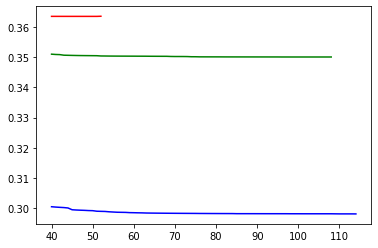

In [67]:
plt.plot([x for x in range(len(losses_0))][40:-1], losses_0[40:-1], "r")
plt.plot([x for x in range(len(losses_1))][40:-1], losses_1[40:-1], "g")
plt.plot([x for x in range(len(losses_2))][40:-1], losses_2[40:-1], "b")
np.argmin(losses_2)

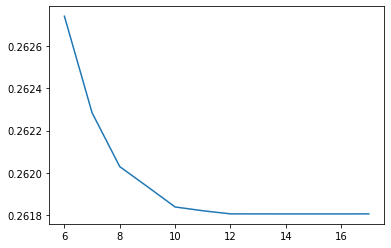

In [64]:
#en degree 1, 1, 1 (ridge)
a = [0, 2, 10, 16, 3, 5, 8, 7, 9, 18, 6, 13, 17, 14, 15, 11, 12, 4, 1]
b = [0, 2, 10, 9, 5, 3, 7, 20, 6, 18, 16, 13, 19, 4, 8, 1, 14, 17, 11, 12, 22, 21, 15]
c = [0, 5, 12, 14, 9, 2, 13, 8, 20, 22, 6, 17, 3, 4, 24, 27, 10, 11, 23, 15, 7, 21, 28, 25, 18, 26, 19, 1, 29, 16]

#en degree 3, 4, 6 (ridge)
d = [0, 2, 10, 20, 38, 21, 23, 3, 32, 16, 19, 37, 1, 18, 29, 54, 26, 43, 7, 28, 13, 39, 41, 34, 52, 8, 44, 25, 17, 24, 27, 4, 42, 31, 35, 14, 9, 45, 50, 22, 51, 53, 47, 40, 48, 12, 15, 6, 33, 11, 30, 36, 5, 46, 49]
e = [0, 2, 10, 43, 9, 36, 24, 31, 76, 19, 5, 27, 3, 13, 71, 47, 57, 33, 8, 38, 6, 49, 87, 53, 30, 1, 23, 45, 69, 18, 25, 4, 16, 64, 40, 62, 84, 68, 46, 74, 29, 67, 75, 70, 80, 28, 17, 51, 86, 7, 72, 50, 58, 77, 26, 82, 37, 32, 55, 83, 35, 21, 65, 12, 59, 15, 11, 42, 41, 14, 61, 78, 34, 39, 66, 56, 22, 81, 44, 88, 54, 60, 48, 63, 20, 85, 73, 52, 79]
f = [0, 34, 12, 14, 9, 71, 2, 47, 8, 37, 149, 22, 124, 30, 101, 5, 63, 88, 1, 59, 146, 117, 62, 44, 27, 36, 41, 100, 31, 168, 154, 67, 23, 24, 3, 17, 32, 90, 153, 66, 70, 7, 173, 165, 46, 119, 56, 139, 85, 53, 20, 4, 114, 43, 61, 148, 150, 170, 10, 128, 92, 121, 11, 6, 93, 35, 64, 122, 151, 159, 147, 60, 89, 118, 125, 18, 141, 157, 65, 115, 57, 82, 111, 143, 99, 28, 52, 51, 80, 142, 13, 129, 160, 152, 94, 163, 26, 39, 126, 40, 69, 167, 96, 105, 123, 58, 116, 50, 135, 120, 33, 91, 95, 136, 112, 73, 130, 131, 15, 25, 83, 21, 137, 79, 84, 98, 156, 127, 75, 68, 45, 161, 103, 174, 48, 171, 55, 113, 172, 102, 109, 138, 54, 72, 108, 166, 16, 132, 107, 155, 104, 164, 106, 110, 77, 19, 134, 76, 145, 87, 29, 81, 133, 144, 86, 74, 78, 49, 169, 140, 162, 97, 158, 42, 38]

#degree 3, 4, 6 (least_square)
g = [0, 2, 10, 20, 38, 21, 23, 3, 32, 16, 19, 37, 1, 18, 29, 54, 26, 43, 7, 28, 49, 39, 41, 34, 52, 13, 31, 25, 8, 44, 46, 24, 27, 17, 4, 42, 45, 9, 6, 40, 22, 35, 14, 50, 51, 53, 5, 15, 48, 12, 47, 33, 30, 11, 36]
h = [0, 2, 10, 43, 9, 36, 24, 31, 76, 19, 5, 27, 3, 13, 71, 49, 35, 33, 47, 8, 16, 6, 87, 53, 30, 79, 45, 1, 23, 67, 40, 4, 38, 69, 86, 68, 46, 52, 18, 62, 84, 75, 48, 51, 70, 17, 7, 85, 77, 80, 28, 72, 50, 26, 37, 54, 32, 74, 29, 63, 25, 73, 58, 83, 60, 82, 64, 57, 55, 21, 65, 11, 12, 59, 15, 42, 20, 41, 14, 78, 34, 39, 61, 66, 22, 56, 44, 88, 81]
i = [0, 34, 12, 14, 9, 71, 2, 47, 8, 37, 149, 22, 124, 30, 101, 5, 63, 88, 1, 59, 146, 117, 62, 44, 27, 36, 41, 31, 100, 168, 154, 67, 23, 24, 3, 17, 32, 153, 66, 61, 70, 7, 165, 46, 173, 56, 139, 85, 53, 20, 4, 114, 148, 147, 60, 89, 118, 128, 43, 150, 170, 92, 121, 10, 90, 119, 6, 93, 35, 64, 122, 151, 125, 159, 18, 141, 157, 40, 156, 65, 115, 57, 96, 28, 99, 95, 82, 111, 143, 52, 51, 80, 142, 81, 13]

#degree 6, 5, 4, (ridge)
j = 
k = 
l = 

In [70]:
tx_tr0, tr0_mean, tr0_std = preprocessing(dat_tr0, 3, cols_idx=[3,8,9,13,16,19,22])
tx_tr0b, tr0_meanb, tr0_stdb= preprocessing(dat_tr0, 3)


7
13


In [53]:
from proj1_helpers import *
DATA_TRAIN_PATH = '/home/toinou/course/ml/ml_proj1/data/train.csv' 
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

tX.T[[22,-1]] = tX.T[[-1,22]]


y_0, y_1, y_2, dat_tr0, dat_tr1, dat_tr2, idx_tr0, idx_tr1, idx_tr2 = split_jet_num(y   ,tX)

tx_tr0, tr0_mean, tr0_std = preprocessing(dat_i=dat_tr0, degree=6)
tx_tr1, tr1_mean, tr1_std = preprocessing(dat_i=dat_tr1, degree=5)
tx_tr2, tr2_mean, tr2_std = preprocessing(dat_i=dat_tr2, degree=4)

# split data in k fold
k_indices_0 = build_k_indices(y_0, k_fold, seed)
k_indices_1 = build_k_indices(y_1, k_fold, seed)
k_indices_2 = build_k_indices(y_2, k_fold, seed)

seed = 383692
#usually 8
k_fold = 6

#lambdas for ridge
lambdas = np.logspace(-11,-6,30)

rmse_tr_0 = []
rmse_te_0 = []
rmse_tr_1 = []
rmse_te_1 = []
rmse_tr_2 = []
rmse_te_2 = []
rmse_tr_3 = []
rmse_te_3 = []

ws_0 =[]
ws_1 =[]
ws_2 =[]
ws_3 =[]


print("started")

#for lambda_ in lambdas:
for lambda_ in lambdas:
    rmse_tr_tmp_0 = []
    rmse_te_tmp_0 = []
    rmse_tr_tmp_1 = []
    rmse_te_tmp_1 = []
    rmse_tr_tmp_2 = []
    rmse_te_tmp_2 = []
    rmse_tr_tmp_3 = []
    rmse_te_tmp_3 = []
    for k in range(k_fold):
        loss_tr_0, loss_te_0, w_0 = cross_validation_ridge(y_0, tx_tr0, k_indices_0, k, lambda_)
        loss_tr_1, loss_te_1, w_1 = cross_validation_ridge(y_1, tx_tr1, k_indices_1, k, lambda_)
        loss_tr_2, loss_te_2, w_2 = cross_validation_ridge(y_2, tx_tr2, k_indices_2, k, lambda_)
        #loss_tr_3, loss_te_3, w_3 = cross_validation_ridge(pred_3, dat_3_, k_indices_3, k, lambda_)

        rmse_tr_tmp_0.append(loss_tr_0)
        rmse_te_tmp_0.append(loss_te_0)
        rmse_tr_tmp_1.append(loss_tr_1)
        rmse_te_tmp_1.append(loss_te_1)
        rmse_tr_tmp_2.append(loss_tr_2)
        rmse_te_tmp_2.append(loss_te_2)
        #rmse_tr_tmp_3.append(loss_tr_3)
        #rmse_te_tmp_3.append(loss_te_3)
    ws_0.append(w_0)
    ws_1.append(w_1)
    ws_2.append(w_2)
    #ws_3.append(w_3)

    
    #combine the loss over the folds
    rmse_tr_0.append(np.mean(rmse_tr_tmp_0))
    rmse_te_0.append(np.mean(rmse_te_tmp_0))
    rmse_tr_1.append(np.mean(rmse_tr_tmp_1))
    rmse_te_1.append(np.mean(rmse_te_tmp_1))
    rmse_tr_2.append(np.mean(rmse_tr_tmp_2))
    rmse_te_2.append(np.mean(rmse_te_tmp_2))
    #rmse_tr_3.append(np.mean(rmse_tr_tmp_3))
    #rmse_te_3.append(np.mean(rmse_te_tmp_3))
    
print("finished")

/home/toinou/Documents/master/ma1/ml/ml_proj1/scripts/proj1_helpers.py:93: RuntimeWarning: Mean of empty slice
  nan_mean = np.nanmean(tx, axis=0)
/home/toinou/Documents/venvs/pyt3.8/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


started
finished


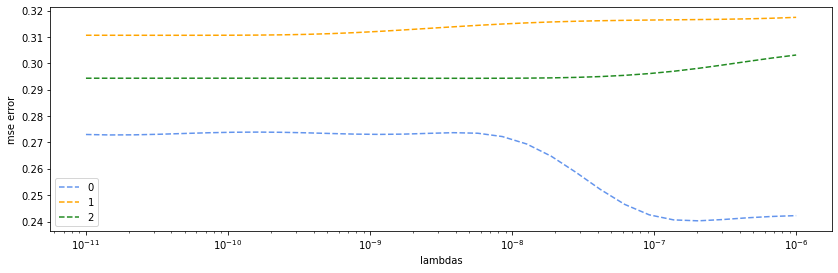

In [54]:
f = plt.figure(figsize=(14,14)) # change this if needed
#degree 1
ax1 = f.add_subplot(311)
ax1.semilogx(lambdas, rmse_te_0, ls="--" , marker="",
             c="cornflowerblue", label="0")
ax1.semilogx(lambdas, rmse_te_1, ls="--" , marker="",
             c="orange", label="1")
ax1.semilogx(lambdas, rmse_te_2, ls="--" , marker="",
             c="forestgreen", label="2")
"""
ax1.semilogx(lambdas, rmse_te_3, ls="--" , marker="",
             c="brown", label="3")
"""
plt.xlabel("lambdas")
plt.ylabel("mse error")
plt.legend()
plt.show()

In [374]:
from proj1_helpers import *
DATA_TRAIN_PATH = '/home/toinou/course/ml/ml_proj1/data/train.csv' 
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

tX.T[[22,-1]] = tX.T[[-1,22]]

seed = 9723861
#usually 8
k_fold = 6

# split data in k fold
k_indices = build_k_indices(y, k_fold, seed)

pred_0, pred_1, pred_2, dat_0_, dat_1_, dat_2_, inds_0, inds_1, inds_2 = preproc_3split(y,tX,[9,10,12])
pred_3, pred_4, pred_5, dat_3_, dat_4_, dat_5_, inds_3, inds_4, inds_5 = preproc_3split(y,tX,[6,7,9])
#pred_6, pred_7, pred_8, dat_6_, dat_7_, dat_8_, inds_6, inds_7, inds_8 = preproc_3split(y,tX,[6,7,9])
pred_8, pred_9, pred_10, dat_8_, dat_9_, dat_10_, inds_8, inds_9, inds_10 = preproc_3split(y,tX,[3,4,6])

rmse_tr_ltsqr3 = []
rmse_te_ltsqr3 = []
rmse_tr_ridge3 = []
rmse_te_ridge3 = []
rmse_tr_ridge3_b = []
rmse_te_ridge3_b = []
rmse_tr_ridge3_c = []
rmse_te_ridge3_c = []
rmse_tr_ridge3_d = []
rmse_te_ridge3_d = []


print("started")

for k in range(k_fold):
    """
    loss_tr_ltsqr3, loss_te_ltsqr3, w_ls3 = cross_validation_ls_3split(pred_0, pred_1, pred_2,
                                                                       dat_0_, dat_1_, dat_2_,
                                                                       inds_0, inds_1, inds_2,
                                                                       k_indices, k)
    """
    
    loss_tr_ltsqr3, loss_te_ltsqr3, w_ls3 = cross_validation_ridge_3split(pred_8, pred_9, pred_10,
                                                                   dat_8_, dat_9_, dat_10_,
                                                                   inds_8, inds_9, inds_10,
                                                                   k_indices, k,
                                                                   [10**-40, 10**-40, 10**-40])
    #0.801 -> 9,10,11
    loss_tr_ridge3, loss_te_ridge3, w_ri3 = cross_validation_ridge_3split(pred_0, pred_1, pred_2,
                                                                       dat_0_, dat_1_, dat_2_,
                                                                       inds_0, inds_1, inds_2,
                                                                       k_indices, k,
                                                                       [2.48*10**-3, 1.18*10**-3, 1.18*10**-3])
    #.803 -> 3,4,6
    loss_tr_ridge3_b, loss_te_ridge3_b, w_ri3_b = cross_validation_ridge_3split(pred_8, pred_9, pred_10,
                                                                   dat_8_, dat_9_, dat_10_,
                                                                   inds_8, inds_9, inds_10,
                                                                   k_indices, k,
                                                                   [10**-4, 4.06*10**-4, 2.72*10**-7])
    #? -> degree intermediaire lambda opti mais moins bon accu
    loss_tr_ridge3_c, loss_te_ridge3_c, w_ri3_c = cross_validation_ridge_3split(pred_3, pred_4, pred_5,
                                                                   dat_3_, dat_4_, dat_5_,
                                                                   inds_3, inds_4, inds_5,
                                                                   k_indices, k,
                                                                   [1.93*10**-3, 1.93*10**-7, 7.20*10**-4])
    #0.805 -> degree intermediaire lambda de 3,4,6
    loss_tr_ridge3_d, loss_te_ridge3_d, w_ri3_d = cross_validation_ridge_3split(pred_3, pred_4, pred_5,
                                                                   dat_3_, dat_4_, dat_5_,
                                                                   inds_3, inds_4, inds_5,
                                                                   k_indices, k,
                                                                   [10**-4, 4.06*10**-4, 2.72*10**-7])
    
    
    #loss_tr_ltsqr, loss_te_ltsqr, w_ls = cross_validation_ls(y, tX_md, k_indices, k)
    #loss_tr_ridge, loss_te_ridge, w_ridge = cross_validation_ridge(y, tX_md, k_indices, k, 10**-4)
    
    rmse_tr_ridge3.append(loss_tr_ridge3)
    rmse_te_ridge3.append(loss_te_ridge3)
    
    rmse_tr_ridge3_b.append(loss_tr_ridge3_b)
    rmse_te_ridge3_b.append(loss_te_ridge3_b)
    
    rmse_tr_ridge3_c.append(loss_tr_ridge3_c)
    rmse_te_ridge3_c.append(loss_te_ridge3_c)
    
    rmse_tr_ridge3_d.append(loss_tr_ridge3_d)
    rmse_te_ridge3_d.append(loss_te_ridge3_d)
    
    rmse_tr_ltsqr3.append(loss_tr_ltsqr3)
    rmse_te_ltsqr3.append(loss_te_ltsqr3)

print("finished")

started
finished


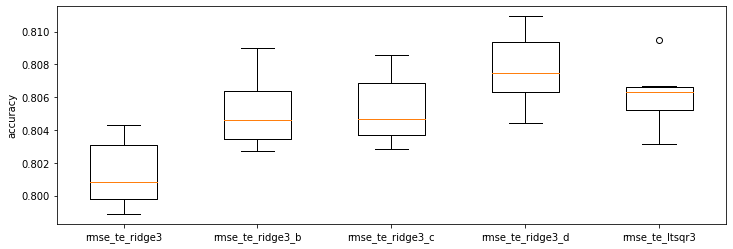

In [375]:
plt.figure(figsize=[12,4])
plt.boxplot([
             rmse_te_ridge3,
             rmse_te_ridge3_b,
             rmse_te_ridge3_c,
             rmse_te_ridge3_d,
             rmse_te_ltsqr3
            ],
            labels=[
                "rmse_te_ridge3",
                "rmse_te_ridge3_b",
                "rmse_te_ridge3_c",
                "rmse_te_ridge3_d",
                "rmse_te_ltsqr3"
            ])
plt.ylabel("accuracy")
plt.show()

In [ ]:
from proj1_helpers import *
DATA_TRAIN_PATH = '/home/toinou/course/ml/ml_proj1/data/train.csv' 
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

tX.T[[22,-1]] = tX.T[[-1,22]]

degrees1 = [3, 4, 6]

degrees2 = [6, 5, 4]

degrees3 = [3, 5, 4]

feats_to_keeps = [
    [0, 2, 10, 20, 38, 21, 23, 3, 32, 16, 19, 37, 1, 18, 29, 54, 26, 43, 7, 28, 13, 39, 41, 34, 52, 8, 44, 25, 17, 24, 27, 4, 42, 31, 35, 14, 9, 45, 50, 22, 51, 53, 47, 40, 48, 12, 15, 6, 33, 11, 30, 36, 5, 46, 49][:49],
    [0, 2, 10, 43, 9, 36, 24, 31, 76, 19, 5, 27, 3, 13, 71, 47, 57, 33, 8, 38, 6, 49, 87, 53, 30, 1, 23, 45, 69, 18, 25, 4, 16, 64, 40, 62, 84, 68, 46, 74, 29, 67, 75, 70, 80, 28, 17, 51, 86, 7, 72, 50, 58, 77, 26, 82, 37, 32, 55, 83, 35, 21, 65, 12, 59, 15, 11, 42, 41, 14, 61, 78, 34, 39, 66, 56, 22, 81, 44, 88, 54, 60, 48, 63, 20, 85, 73, 52, 79][:83],
    [0, 34, 12, 14, 9, 71, 2, 47, 8, 37, 149, 22, 124, 30, 101, 5, 63, 88, 1, 59, 146, 117, 62, 44, 27, 36, 41, 100, 31, 168, 154, 67, 23, 24, 3, 17, 32, 90, 153, 66, 70, 7, 173, 165, 46, 119, 56, 139, 85, 53, 20, 4, 114, 43, 61, 148, 150, 170, 10, 128, 92, 121, 11, 6, 93, 35, 64, 122, 151, 159, 147, 60, 89, 118, 125, 18, 141, 157, 65, 115, 57, 82, 111, 143, 99, 28, 52, 51, 80, 142, 13, 129, 160, 152, 94, 163, 26, 39, 126, 40, 69, 167, 96, 105, 123, 58, 116, 50, 135, 120, 33, 91, 95, 136, 112, 73, 130, 131, 15, 25, 83, 21, 137, 79, 84, 98, 156, 127, 75, 68, 45, 161, 103, 174, 48, 171, 55, 113, 172, 102, 109, 138, 54, 72, 108, 166, 16, 132, 107, 155, 104, 164, 106, 110, 77, 19, 134, 76, 145, 87, 29, 81, 133, 144, 86, 74, 78, 49, 169, 140, 162, 97, 158, 42, 38][:168]
                 ]

y_0, y_1, y_2, dat_tr0, dat_tr1, dat_tr2, idx_tr0, idx_tr1, idx_tr2 = split_jet_num(y   ,tX)

#log-transform, augment features using polynomial basis and standardize the subsets individualy
tx_tr0, tr0_mean, tr0_std = preprocessing(dat_i=dat_tr0, degree=degrees1[0], kept_cols=feats_to_keeps[0])
tx_tr1, tr1_mean, tr1_std = preprocessing(dat_i=dat_tr1, degree=degrees1[1], kept_cols=feats_to_keeps[1])
tx_tr2, tr2_mean, tr2_std = preprocessing(dat_i=dat_tr2, degree=degrees1[2], kept_cols=feats_to_keeps[2])

tx_tr3, tr3_mean, tr3_std = preprocessing(dat_i=dat_tr0, degree=degrees1[0], kept_cols=feats_to_keeps[0], cols_idx=[3,8,9,13,16,19,22])
tx_tr4, tr4_mean, tr4_std = preprocessing(dat_i=dat_tr1, degree=degrees1[1], kept_cols=feats_to_keeps[1], cols_idx=[3,8,9,13,16,19,22])
tx_tr5, tr5_mean, tr5_std = preprocessing(dat_i=dat_tr2, degree=degrees1[2], kept_cols=feats_to_keeps[2], cols_idx=[3,8,9,13,16,19,22])

#best submission 0.815
tx_tr6, tr6_mean, tr6_std = preprocessing(dat_i=dat_tr0, degree=degrees2[0])
tx_tr7, tr7_mean, tr7_std = preprocessing(dat_i=dat_tr1, degree=degrees2[1])
tx_tr8, tr8_mean, tr8_std = preprocessing(dat_i=dat_tr2, degree=degrees2[2])


rmse_tr_ltsqr3 = []
rmse_te_ltsqr3 = []
rmse_tr_logreg3 = []
rmse_te_logreg3 = []
rmse_tr_ridge3_b = []
rmse_te_ridge3_b = []
rmse_tr_ridge3_c = []
rmse_te_ridge3_c = []
rmse_tr_ridge3_d = []
rmse_te_ridge3_d = []
rmse_tr_ridge3_e = []
rmse_te_ridge3_e = []
rmse_tr_ridge3_f = []
rmse_te_ridge3_f = []

seed = 281236
#usually 8
k_fold = 6

# split data in k fold
k_indices = build_k_indices(y, k_fold, seed)


print("started")

for k in range(k_fold):
    
    
    #least_squares
    loss_tr_ltsqr3, loss_te_ltsqr3, w_ls3 = cross_validation_ls_3split(y_0, y_1, y_2,
                                                                   tx_tr6, tx_tr7, tx_tr8,
                                                                   idx_tr0, idx_tr1, idx_tr2,
                                                                   k_indices, k)
    #log regression
    loss_tr_logreg3, loss_te_logreg3, w_lr = cross_validation_logreg_3split(y_0,y_1,y_2,
                                                                            tx_tr6, tx_tr7, tx_tr8,
                                                                            idx_tr0, idx_tr1, idx_tr2,
                                                                            k_indices, k, 0.01, 2000,
                                                                            error=False)
    
    #.803
    loss_tr_ridge3_b, loss_te_ridge3_b, w_ri3_b = cross_validation_ridge_3split(y_0, y_1, y_2,
                                                                   tx_tr3, tx_tr4, tx_tr5,
                                                                   idx_tr0, idx_tr1, idx_tr2,
                                                                   k_indices, k,
                                                                   [10**-4, 4.06*10**-4, 2.72*10**-7],
                                                                    False)
    
    # BEST SUBMIT 0.814
    loss_tr_ridge3_e, loss_te_ridge3_e, w_ri3_e = cross_validation_ridge_3split(y_0,y_1,y_2,
                                                                   tx_tr6, tx_tr7, tx_tr8,
                                                                   idx_tr0, idx_tr1, idx_tr2,
                                                                   k_indices, k,
                                                                   [2.04*10**-7, 4.89*10**-11, 3.86*10**-9],
                                                                    False)       
    
    #loss_tr_ltsqr, loss_te_ltsqr, w_ls = cross_validation_ls(y, tX_md, k_indices, k)
    #loss_tr_ridge, loss_te_ridge, w_ridge = cross_validation_ridge(y, tX_md, k_indices, k, 10**-4)
    
    rmse_tr_ltsqr3.append(loss_tr_ltsqr3)
    rmse_te_ltsqr3.append(loss_te_ltsqr3)
    
    rmse_tr_logreg3.append(loss_tr_logreg3) 
    rmse_te_logreg3.append(loss_te_logreg3)
    
    rmse_tr_ridge3_b.append(loss_tr_ridge3_b)
    rmse_te_ridge3_b.append(loss_te_ridge3_b)
    
    rmse_tr_ridge3_d.append(loss_tr_ridge3_d)
    rmse_te_ridge3_d.append(loss_te_ridge3_d)
    
    rmse_tr_ridge3_e.append(loss_tr_ridge3_e)
    rmse_te_ridge3_e.append(loss_te_ridge3_e)
    
    rmse_tr_ridge3_f.append(loss_tr_ridge3_f)
    rmse_te_ridge3_f.append(loss_te_ridge3_f)
    

print("finished")

started


In [ ]:
plt.figure(figsize=[12,4])
plt.boxplot([
             rmse_te_ltsqr3,
             rmse_te_logreg3,
             rmse_te_ridge3_b,
             rmse_te_ridge3_e
            ],
            labels=[
                "Least squares",
                "Log reg",
                "Previous best",
                "SpecialSauce"
            ])
plt.ylabel("accuracy")
plt.ylim([0.5,0.85])
plt.show()

## Generate predictions and save ouput in csv format for submission:

In [348]:
from implementations import *
DATA_TEST_PATH = '/home/toinou/course/ml/ml_proj1/data/test.csv'
y, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)
tX_test.T[[22,-1]] = tX_test.T[[-1,22]]

In [349]:
### SPLIT 3
OUTPUT_PATH = '/home/toinou/course/ml/ml_proj1/sub22.csv'
pred = np.zeros(tX_test.shape[0])
pred_0, pred_1, pred_2, pred_3, dat_0_, dat_1_, dat_2_, dat_3_, inds_0, inds_1, inds_2, inds_3 = preproc_4split(pred,tX_test,[9,10,9,11])
y_pred_0 = predict_labels(w_0, dat_0_)
y_pred_1 = predict_labels(w_1, dat_1_)
y_pred_2 = predict_labels(w_2, dat_2_)
y_pred_3 = predict_labels(w_3, dat_3_)
pred[inds_0] = y_pred_0
pred[inds_1] = y_pred_1
pred[inds_2] = y_pred_2
pred[inds_3] = y_pred_3

create_csv_submission(ids_test, pred, OUTPUT_PATH)